# Lab 3: Stochastic Gradient Descent

### Qabel Mohamed Aymen
### Florez de la Colina Inès

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header = None)
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9713119746619564

## Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [51]:
class LogisticRegression():
    
    
    def __init__(self, alpha=0, beta = 0.9, gamma = 0.999, lr=0.1, bsize=50, max_iter=150, method = 'Classic',eps = 1e-7, Debias = True):
        self.alpha_ = alpha
        self.beta_ = beta
        self.gamma_ = gamma
        self.lr_ = lr
        self.bsize_ = bsize
        self.max_iter_ = max_iter
        self.coef_ = None
        self.f_history_ = None
        self.f_grad_history = None
        self.method_ = method
        self.eps_ = eps
        self.Debias_ = Debias
    
    def logistic(self,z):
        """Computes the logistic function"""
        return 1/(1+np.exp(-z))
    
        
    def fit(self,X,y):
        """Computes the model parameters after a gradient descent technique is chosen"""
        #Adding a column of ones for the bias
        X = np.concatenate([np.ones((len(X),1)),X], axis=1)
        n_samples,p_feat = X.shape
        self.coef_ = np.zeros(p_feat)
        M_t = np.zeros(p_feat)
        S_t = np.zeros(p_feat)
        self.f_history_ = np.zeros(self.max_iter_)
        iteration = 1
        loss1=0
        
        def compute_grad(theta,batch_indices):
            """Computes the gradient of the loss function"""
            gradient = np.zeros(p_feat)
            for i in batch_indices:
                gradient+= -y[i]*self.logistic(-y[i]*theta.T@X[i])*X[i]
            return gradient + self.alpha_*self.coef_
        
        def compute_loss(theta):
            """Computes the loss function"""
            loss = 0
            for i in range(n_samples):
                loss += -np.log(self.logistic(y[i]*theta.T@X[i]))
            return loss/n_samples + self.alpha_*(np.linalg.norm(theta)**2)/2
        
        #Generates the batch indices and performs the gradient method selected
        while iteration<= self.max_iter_:
            batch_indices = random.sample(range(n_samples), self.bsize_)
            gradient = compute_grad(self.coef_,batch_indices)

            if self.method_ == 'Classic':
                self.coef_ -=  (self.lr_/iteration) * gradient
            if self.method_ == 'Adam':
                M_t = self.beta_ * M_t + (1-self.beta_)*gradient
                S_t = self.gamma_ * S_t + (1-self.gamma_)*(gradient**2)
                if self.Debias_ == True:
                    M_t = M_t/(1-self.beta_**iteration)
                    S_t = S_t/(1-self.gamma_**iteration)
                self.coef_ -= self.lr_ * M_t/(S_t**0.5 + self.eps_)
            if self.method_ == 'Adagrad':
                M_t = gradient
                S_t = S_t + gradient**2
                self.coef_ -= self.lr_*M_t/(S_t**0.5+self.eps_)
            if self.method_ == 'RMSProp':
                M_t = gradient
                S_t = self.gamma_ * S_t + (1-self.gamma_)*(gradient**2)
                self.coef_ -= self.lr_*M_t/(S_t**0.5+self.eps_)
            if self.method_ == 'Momentum':
                M_t = self.beta_ * M_t + gradient
                self.coef_ -= self.lr_*M_t
            
        #Adds the loss value computed at iteration i
            loss1 = compute_loss(self.coef_)
            self.f_history_[iteration-1] = loss1
            iteration +=1
            
        
    def predict(self, X_test):
        """Predicts the data and plots the variations of the loss function"""
        n,p = X_test.shape
        y_pred = np.zeros(n)
        X_test =np.concatenate([np.ones((len(X_test),1)),X_test], axis=1)
        for j in range(n):
            prediction = self.logistic(self.coef_.T@X_test[j])
            if prediction>= 0.5:
                y_pred[j] = 1
            else: 
                y_pred[j] = -1        
        return y_pred

Apply to the data

## Stochastic gradient descent

### Tests 

We get an accuracy of 0.9703983432817639 for a learning rate of 0.001
We get an accuracy of 0.9696674381776099 for a learning rate of 0.01
We get an accuracy of 0.9696674381776099 for a learning rate of 0.1
We get an accuracy of 0.9696674381776099 for a learning rate of 1


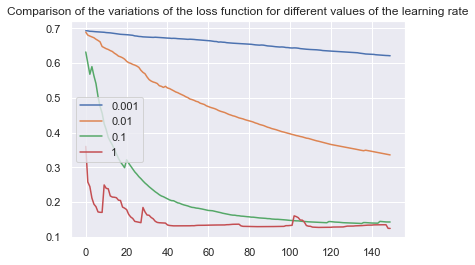

In [59]:
import random
X = X_train
y = y_train


learning_rate = [1e-3, 1e-2, 1e-1, 1]
for i in learning_rate:
    print("We get an accuracy of " + str(accuracy_score(y_test, y_pred)) + " for a learning rate of " + str(i))
    classic = LogisticRegression(lr=i, bsize = 1, max_iter = 150)
    classic.fit(X,y)
    y_pred = classic.predict(X_test)
    loss = classic.f_history_
    plt.plot(loss, label = str(i))
plt.legend()
plt.title('Comparison of the variations of the loss function for different values of the learning rate')
plt.show()

### Comments 

We observe, by changing the learning rate of our gradient descent, a change of the rate of convergence of the loss function to its minimum. Conversely, if the value is too big then gradient descent misses the minimum and diverges. For too small values of the learning rate, we have a slow convergence. Thus, it would be interesting to continue our analysis by fine tunning the learning rate parameter, to find its optimal value. We will now set the learning rate to 0.1.


## Acceleration method: Adam Gradient Descent 

With the optimal parameters according to the litterature.

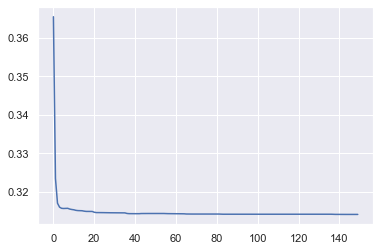

Accuracy = 0.9707637958338409


In [57]:
Adam = LogisticRegression(beta = 0.9, gamma = 0.999, bsize = 50, method = 'Adam', max_iter = 150)  
Adam.fit(X,y)
y_pred = Adam.predict(X_test) 
loss = Adam.f_history_
plt.plot(loss) 
plt.show()
print("Accuracy = " + str(accuracy_score(y_test, y_pred)))

We can see that compared to the stochastic gradient descent, the convergence here is faster.

### Tests for the beta parameter

We get an accuracy of 0.9738092337678158 for beta = 0.5
We get an accuracy of 0.9736874162504568 for beta = 0.7
We get an accuracy of 0.969911073212328 for beta = 0.9


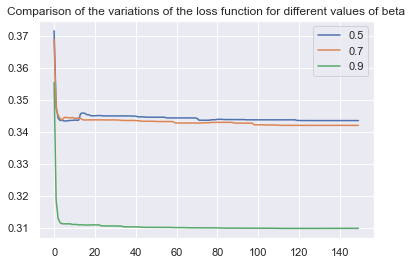

In [60]:
import random
X = X_train
y = y_train


beta_value = [0.5, 0.7, 0.9]
accuracy = []
for i in beta_value:
    Adam = LogisticRegression(beta = i, gamma = 0.999, bsize = 50, method = 'Adam', max_iter = 150)
    Adam.fit(X,y)
    y_pred = Adam.predict(X_test)   
    loss = Adam.f_history_
    plt.plot(loss, label = str(i)) 
    print("We get an accuracy of " + str(accuracy_score(y_test, y_pred)) + " for beta = " + str(i))

plt.legend()
plt.title('Comparison of the variations of the loss function for different values of beta')
plt.show()

### Comments

We observe that the accuracy found for the three different values of beta is very similar. The shape of the variation of the loss function of the Adam descent is similar as well. The biggest difference between the three models is the value of the minimum found for the loss function. This value decreases while beta increases to 0.9.

### Tests for the gamma parameter

For the following tests, we have decided to set the Debias parameter to False to avoid any type of overflow problem.

We get an accuracy of 0.9795955658423682 for gamma = 0.9
We get an accuracy of 0.981910098672189 for gamma = 0.95
We get an accuracy of 0.9809964672919966 for gamma = 0.999


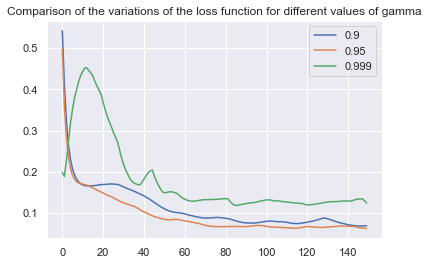

In [77]:
import random
X = X_train
y = y_train

gamma_value = [0.9, 0.95, 0.999]
for i in gamma_value:
    Adam = LogisticRegression(beta = 0.9, gamma = i, bsize = 50, method = 'Adam', max_iter = 150, Debias = False)
    Adam.fit(X,y)
    y_pred = Adam.predict(X_test)   
    loss = Adam.f_history_
    plt.plot(loss, label = str(i)) 
    print("We get an accuracy of " + str(accuracy_score(y_test, y_pred)) + " for gamma = " + str(i))

plt.legend()
plt.title('Comparison of the variations of the loss function for different values of gamma')
plt.show()

### Comments

As to avoid overflow, the Debias parameter was set to False, it is harder to comment the results. We can observe that the curves we obtain for 0.9 and 0.95 are very similar and the one for 0.999 increases before starting to decrease and converge. With this debias paramter set to false, the best value for gamma here seems to be 0.95 becayse it is the one for which the convergence to the minimum is faster.

### Tests for the Batch size

We get an accuracy of 0.9688756243147765 for batchsize = 1
We get an accuracy of 0.9712510659032769 for batchsize = 25
We get an accuracy of 0.9708856133511999 for batchsize = 50
We get an accuracy of 0.9707637958338409 for batchsize = 100


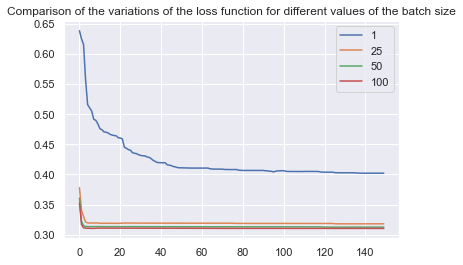

In [64]:
import random
X = X_train
y = y_train

batch_value = [1, 25, 50, 100]
for i in batch_value:
    Adam = LogisticRegression(beta = 0.9, gamma = 0.999, bsize = i, method = 'Adam', max_iter = 150)
    Adam.fit(X,y)
    y_pred = Adam.predict(X_test)   
    loss = Adam.f_history_
    plt.plot(loss, label = str(i)) 
    print("We get an accuracy of " + str(accuracy_score(y_test, y_pred)) + " for batchsize = " + str(i))

plt.legend()
plt.title('Comparison of the variations of the loss function for different values of the batch size')
plt.show()

### Comments

Increasing the number of batches increases the convergence speed of the loss function. The higher the number, the faster the convergence. This was expected, because the higher the number of batches is, the more accurate the gradient we compute is going to be.

In [35]:
Adam = LogisticRegression(beta = 0.85, gamma = 0.9, bsize = 150, method = 'Adam', max_iter = 700)
Adam.fit(X,y)
y_pred = Adam.predict(X_test)
accuracy_score(y_test, y_pred)

0.9867218906078694

### Comments

We have chosen these parameters to show that we can reach a better accuracy with them. In a general machine learning problem, according to what we would like to maximize (accuracy, recall, precision...), the best parameters for the model are not always the "optimal" ones. Once again, it would be interesting to fine tune the paramters to find the ones that maximize the accuracy in this case.

## Other Accelarion Methods

In the following, we have decided to implement other acceleration methods just to show the different results we obtain with those methods. As we have already tested the parameters for the algorithms presented above we will just show the variations of the loss function and compute the accuracy for the remaining methods.

## Acceleration Method: ADAGRAD Gradient Descent

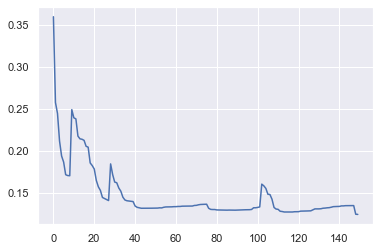

Accuracy = 0.9754537702521623


In [65]:
Adagrad = LogisticRegression(beta = 0.9, gamma = 0.999, bsize = 50, method = 'Adagrad', max_iter = 150)
Adagrad.fit(X,y)
y_pred = Adagrad.predict(X_test)   
loss = classic.f_history_
plt.plot(loss) 
plt.show()
print("Accuracy = " + str(accuracy_score(y_test, y_pred)))

## Acceleration Method : RMS Prop gradient descent

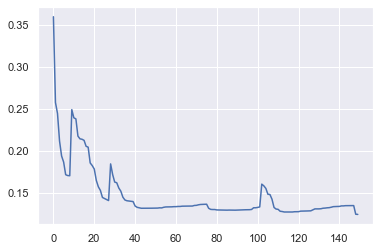

Accuracy = 0.9778292118406627


In [68]:
RMSProp = LogisticRegression(beta = 0.9, gamma = 0.999, bsize = 50, method = 'RMSProp', max_iter = 150)
RMSProp.fit(X,y)
y_pred = RMSProp.predict(X_test)   
loss = classic.f_history_
plt.plot(loss) 
plt.show()
print("Accuracy = " + str(accuracy_score(y_test, y_pred)))

## Accelaration Method : Momentum Gradient Descent

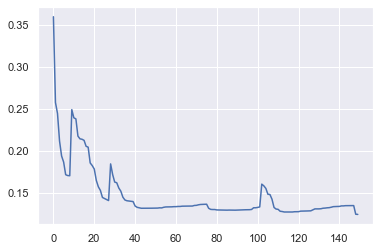

Accuracy = 0.9777683030819831


In [69]:
Momentum = LogisticRegression(beta = 0.9, gamma = 0.999, bsize = 50, method = 'Momentum', max_iter = 150)
Momentum.fit(X,y)
y_pred = Momentum.predict(X_test)   
loss = classic.f_history_
plt.plot(loss) 
plt.show()
print("Accuracy = " + str(accuracy_score(y_test, y_pred)))